# Comparing and Integrating among experiments 

## Introduction

The aim of this tutorial is to use the ExperimentSet API to compare the results between two experiment using the Experiment and ExperimentSet classes. 

## Background: 


In the current tutorial, we are going to analyze the results obtained in the paper for quantifiying the impact of initial cell counts on the identified HLA-DR immunopeptidome of PBMC using the IPTK library. 

## Load the Modules 

In [1]:
from IPTK.IO.InFunctions import parse_xml_based_format_to_identification_table
import numpy as np
import pandas as pd 
from IPTK.Utils.UtilityFunction import get_experiment_summary, combine_summary
from IPTK.Classes.Experiment import Experiment
from IPTK.Classes.ExperimentalSet import ExperimentSet
from IPTK.Classes.Database import SeqDB, GeneExpressionDB, CellularLocationDB,OrganismDB
from IPTK.Classes.Tissue import Tissue
from IPTK.Classes.HLASet import HLASet
from IPTK.Classes.Proband import Proband
from IPTK.Classes.Peptide import Peptide 
from IPTK.Visualization.vizTools import plot_parent_protein_expression_in_tissue,plotly_parent_protein_expression_in_tissue
from IPTK.Visualization.vizTools import plot_gene_expression_vs_num_peptides
from IPTK.Visualization.vizTools import plot_num_protein_per_location
from IPTK.Visualization.vizTools import plot_num_peptide_per_go_term
from IPTK.Visualization.vizTools import plot_overlap_heatmap
from IPTK.IO.OutFunctions import write_auto_named_peptide_to_fasta
from IPTK.Analysis.AnalysisFunction import compute_binary_distance 
from IPTK.Visualization.vizTools import plot_protein_coverage
import matplotlib.pyplot as plt
from IPTK.Visualization.vizTools import plot_coverage_and_annotation 
from IPTK.IO.InFunctions import download_pdb_entry
from typing import List,Set,Dict 
import pandas as pd 
import numpy as np
import random 
import seaborn as sns 
from IPTK.Visualization.vizTools import plot_paired_represention 
from IPTK.Analysis.AnalysisFunction import compute_ic_distance_experiments 
from IPTK.Visualization.vizTools import plot_MDS_from_ic_coverage

## Define the experiment-invarients 

In [2]:
donor: Proband = Proband(name='Tutorial_2') 
hlas: HLASet = HLASet(hlas=['HLA-DRB1*15:01','HLA-DRB1*13:01'])
seqs: SeqDB = SeqDB(path2fasta="database/human_proteome.fasta")
expresson_profile: GeneExpressionDB= GeneExpressionDB()
protein_locations: CellularLocationDB= CellularLocationDB()
tissue: Tissue = Tissue(name='total PBMC',
                        main_exp_value=expresson_profile, 
                        main_location=protein_locations)

## Load the input tables

In [3]:
# load rep1 with 5e7 cells 
rep1_5e7: pd.DataFrame = parse_xml_based_format_to_identification_table(
    path2XML_file="idXML/0810202_0.5_all_ids_merged_psm_perc_filtered.idXML",
    path2fastaDB="database/human_proteome.fasta",
    is_idXML= True) 
# load rep1 with 1e8 cells 
rep1_1e8: pd.DataFrame = parse_xml_based_format_to_identification_table(
    path2XML_file="idXML/0810202_1_all_ids_merged_psm_perc_filtered.idXML",
    path2fastaDB="database/human_proteome.fasta",
    is_idXML= True) 
# load rep2 with 5e7 cells 
rep2_5e7: pd.DataFrame = parse_xml_based_format_to_identification_table(
    path2XML_file="idXML/27112020_0.5_all_ids_merged_psm_perc_filtered.idXML",
    path2fastaDB="database/human_proteome.fasta",
    is_idXML= True) 
# load rep2 with 1e8 cells 
rep2_1e8: pd.DataFrame = parse_xml_based_format_to_identification_table(
    path2XML_file="idXML/27112020_1_all_ids_merged_psm_perc_filtered.idXML",
    path2fastaDB="database/human_proteome.fasta",
    is_idXML= True) 

## Create the experiments 


In [4]:
# define experiment for rep1 5e7 cells 
exp_rep1_5e7= Experiment(proband=donor,hla_set=hlas,tissue=tissue,database=seqs, 
                 ident_table=rep1_5e7)
# define experiment for rep1 1e8 cells 
exp_rep1_1e8= Experiment(proband=donor,hla_set=hlas,tissue=tissue,database=seqs, 
                 ident_table=rep1_1e8)
# define experiment for rep2 5e7 cells 
exp_rep2_5e7= Experiment(proband=donor,hla_set=hlas,tissue=tissue,database=seqs, 
                 ident_table=rep2_5e7)
# define experiment for rep2 1e8 cells 
exp_rep2_1e8= Experiment(proband=donor,hla_set=hlas,tissue=tissue,database=seqs, 
                 ident_table=rep2_1e8)

## Create an ExperimentalSet Object 

In [5]:
exps: ExperimentSet = ExperimentSet(**{'rep1_5e7':exp_rep1_5e7, 
                                    'rep1_1e8':exp_rep1_1e8, 
                                    'rep2_5e7':exp_rep2_5e7,
                                    'rep2_1e8':exp_rep2_1e8})

## Analyzing the overlap among the experiments in the set

### peptide level overlap 

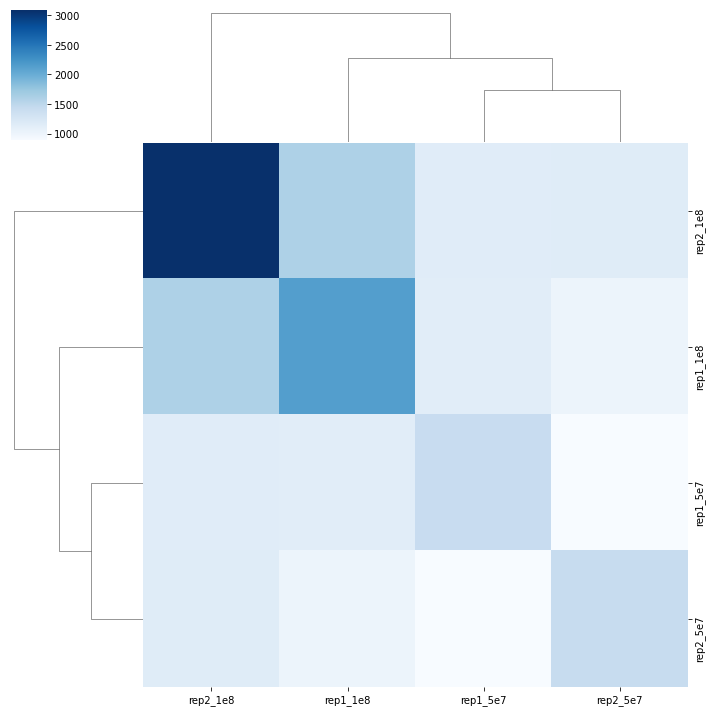

In [6]:
peptide_overlap = exps.compute_peptide_overlap_matrix() 
fig=plot_overlap_heatmap(peptide_overlap,plotting_kwargs={"cmap":"Blues","annot_kws":{"size": 24}})

### protein level overlap 

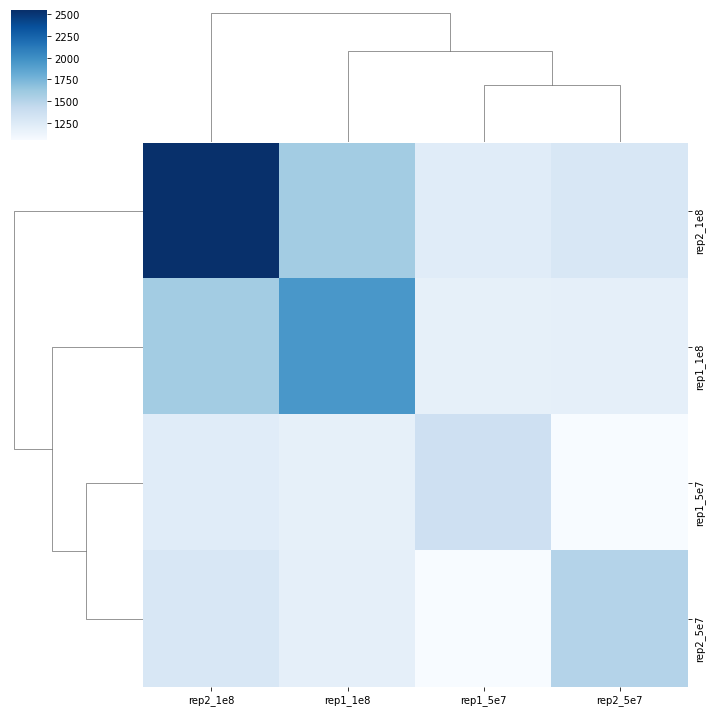

In [7]:
peptide_overlap = exps.compute_protein_overlap_matrix() 
fig=plot_overlap_heatmap(peptide_overlap,plotting_kwargs={"cmap":"Blues","annot_kws":{"size": 24}})

### Immunopeptidomic coverage and MDS plots 

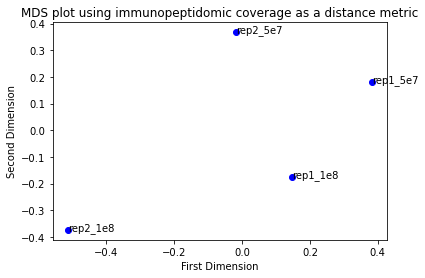

In [8]:
ic_distance=compute_ic_distance_experiments(exps)
fig=plot_MDS_from_ic_coverage(ic_distance)

### Compute peptide representation over the set 

let's try to get an idea about the number of times a peptides was observed over the experiment set, 
the number of times peptides where observed over all the experiments in the experiment set. 

In [9]:
peptide_counts = exps.compute_peptide_representation_count()

#### let's visualize the peptide counts  

Text(0, 0.5, 'Counts')

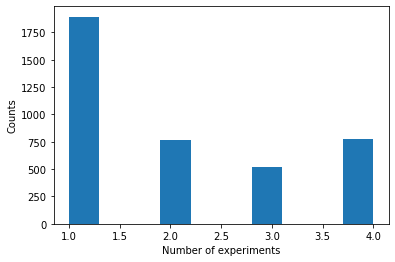

In [10]:
counts=[val for key, val in peptide_counts.items()]
## compute a histogram of the results 
plt.hist(counts) 
plt.xlabel('Number of experiments')
plt.ylabel('Counts')

### We can also go for protein representation over the set

In [11]:
protein_counts = exps.compute_protein_representation_count() 

Text(0, 0.5, 'Counts')

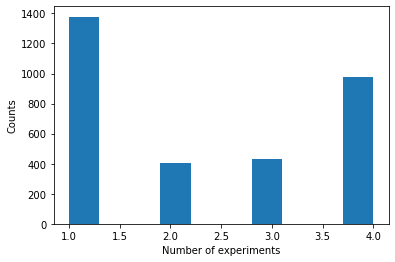

In [12]:
counts=[val for key, val in protein_counts.items()]
## compute a histogram of the results 
plt.hist(counts) 
plt.xlabel('Number of experiments')
plt.ylabel('Counts')

### The coverage of proteins computed over the entire experiment set 

In [13]:
### Let's look at the coverage over the entire set 
coverage_entire_set = exps.compute_protein_coverage_over_the_set() # This might take a couple of minutes 

In [44]:
### let's visualize the coverage of one randomly selected protein 
random_id = random.choice(list(coverage_entire_set.keys()))

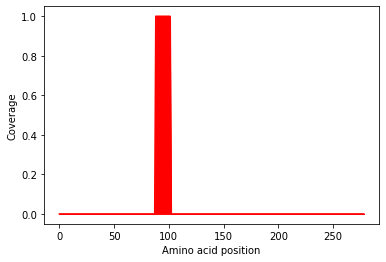

In [46]:
fig=plot_protein_coverage(coverage_entire_set[random_id])

### Compare the coverage between two experiments 

In [47]:
# first let's get the proteins that are inferred in all experiemnts 
all_proteins = exps.get_proteins_present_in_all()

In [49]:
# get the accession of a random protein 
random_prot=random.choice(all_proteins)

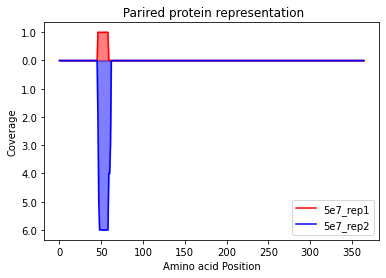

In [52]:
# plot the pair representation 
fig=plot_paired_represention(protein_one_repr={'5e7_rep1':exp_rep1_5e7.get_mapped_protein(random_prot)},
                         protein_two_repr={'5e7_rep2':exp_rep2_5e7.get_mapped_protein(random_prot)})

### Exporting the results 

Next, let's assume that we are interested in a more indepth downstream analysis of the peptides that are defined in all the experiments in the set. This can be done as follow,  

In [53]:
peptides_present_in_all = exps.get_peptides_present_in_all() 

In [55]:
print(f'Number of peptides defined in all experiments is: {len(peptides_present_in_all)}')

Number of peptides defined in all experiments is: 776


we can then export the results as a fasta file as follow

In [57]:
write_auto_named_peptide_to_fasta(peptides_present_in_all,'peptides_present_in_all.fasta')